In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [ ]:
def convert2map_coordinates(x, y, scale,origin):
    return (x*scale+origin[0], y*scale+origin[1])

def convert2world_coordinates(x, y, scale,origin):
    return (x-origin[0])//scale, (y-origin[1])//scale

In [ ]:
image_size = 2000
scale = 50
origin = [image_size//2, image_size//2]
map = np.zeros([image_size, image_size], dtype=np.uint8)
low = [-3, -4]
high = [3, 2]
low_map = convert2map_coordinates(low[0], low[1], scale, origin)
high_map = convert2map_coordinates(high[0], high[1], scale, origin)
map[low_map[1]:high_map[1], low_map[0]:high_map[0]] = 255

In [ ]:
cv2.imwrite('single_room_map.png', map)

In [ ]:
plt.imshow(map, cmap='gray')

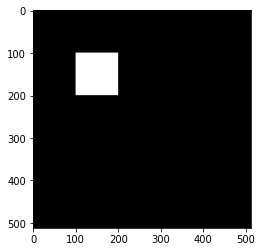

In [4]:
import torch
test_image = torch.zeros([512,512])
test_image[100:200,100:200] = 1
plt.imshow(test_image.numpy(), cmap='gray')

In [ ]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])


def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x


theta = torch.rand(10)*np.pi/2
rot_mat = get_batch_rot_mat(theta)
grid = F.affine_grid(rot_mat, test_image.view(-1,1,512,512).size()).type(dtype)
x = F.grid_sample(x, grid)

In [ ]:
rotated_image = rot_img(test_image.view(1,1,512,512), np.pi/4, torch.float32)
plt.imshow(rotated_image.squeeze(0).permute(1,2,0)/255)

In [ ]:
out = TF.rotate(test_image.view(1,1,512,512), 30)
plt.imshow(out.squeeze(0).permute(1,2,0)/255)

In [5]:
def get_batch_rot_mat(theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    return torch.stack([cos_theta, -sin_theta, torch.zeros_like(sin_theta)+0.25, sin_theta, cos_theta, torch.zeros_like(sin_theta)+0.25], dim=1).reshape(-1,2,3)#.permute(0,2,1)
    

In [6]:
image = cv2.imread("/home/niranjan/Projects/Fetch/curious_dog_isaac/legged_gym/resources/room_layout.png",0)
image_size = 1000
dx = image_size//20
image = cv2.resize(image,(image_size,image_size)).astype(np.float32)
num_envs = 360
image_batch = torch.tensor(image, device=torch.device("cuda")).repeat(num_envs,1,1).view(num_envs,1,1000,1000)
theta = torch.rand(num_envs)*np.pi/4
agent_pos_x = torch.rand(num_envs)*5 - 3
agent_pos_y = torch.rand(num_envs)*5 - 2.5
rot_mat = get_batch_rot_mat(theta).to(torch.device("cuda"))
for i in range(num_envs):
    image_batch[i,0,int(agent_pos_x[i]*dx+image_size//2)-10:int(agent_pos_x[i]*dx+image_size//2)+10,
                    int(agent_pos_y[i]*dx+image_size//2)-10:int(agent_pos_y[i]*dx+image_size//2)+10] = 255
rot_mat[:,0,-1] = agent_pos_y*dx/image_size*2
rot_mat[:,1,-1] = agent_pos_x*dx/image_size*2
grid = F.affine_grid(rot_mat, image_batch.size())
x = F.grid_sample(image_batch, grid).cpu().numpy()

/home/niranjan/anaconda3/envs/rlgpu/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


RuntimeError: CUDA out of memory. Tried to allocate 2.68 GiB (GPU 0; 11.90 GiB total capacity; 5.37 GiB already allocated; 1.32 GiB free; 5.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:

plt.imshow(x[1,0,...])

In [ ]:
plt.imshow(x[3,0,400:600,400:600])